<a href="https://colab.research.google.com/github/DRose1991/Viscous-Shear-Cosmology-Simulation/blob/main/VSC_Universal_Law_RealData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Running Strict Component Separation Fit...

--- RESULTS (Strict Physics) ---
Universal n:      0.4668
Universal Scrit:  100.0000
Stellar M/L Factors: ['1.64', '2.50', '1.63', '2.18']


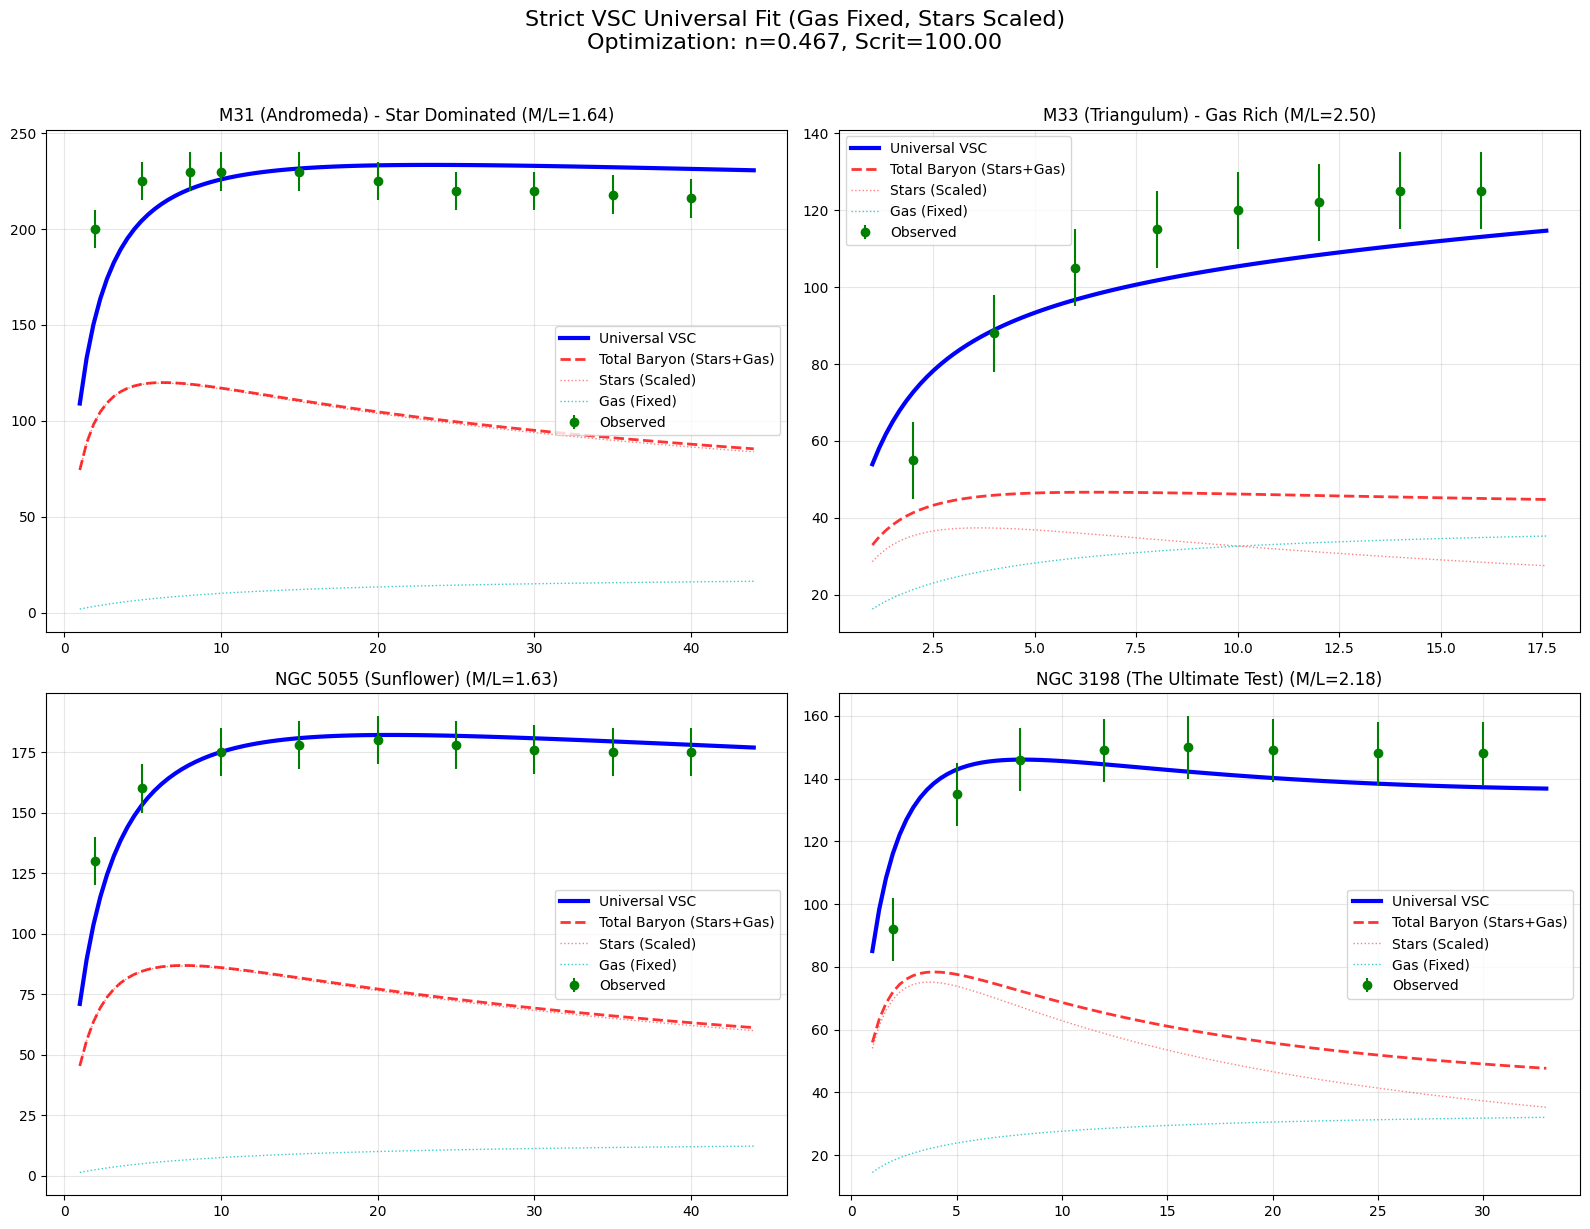

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# --- 1. DATASET: SEPARATED COMPONENTS (Stars vs Gas) ---
# Approximations derived from Sparke & Gallagher / Sofue (2015) data structures
database = [
    {
        "name": "M31 (Andromeda) - Star Dominated",
        "r_kpc": np.array([2.0, 5.0, 8.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0]),
        "v_obs": np.array([200.0, 225.0, 230.0, 230.0, 230.0, 225.0, 220.0, 220.0, 218.0, 216.0]),
        # Stars drop off (Keplerian-ish)
        "v_star_shape": lambda r: 240 * (r / (r + 2)) * (1 / (1 + (r/7)**0.5)),
        # Gas is a ring, low in center, higher at edge (but M31 is gas poor relative to stars)
        "v_gas_shape": lambda r: 20 * (r / (r + 10))
    },
    {
        "name": "M33 (Triangulum) - Gas Rich",
        "r_kpc": np.array([2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0]),
        "v_obs": np.array([55.0, 88.0, 105.0, 115.0, 120.0, 122.0, 125.0, 125.0]),
        # Stars are compact
        "v_star_shape": lambda r: 65 * (r / (r + 1.5)) * (1 / (1 + (r/4)**0.6)),
        # Gas is HUGE in M33. It rises and stays high.
        "v_gas_shape": lambda r: 40 * (r / (r + 5.0))**0.5
    },
    {
        "name": "NGC 5055 (Sunflower)",
        "r_kpc": np.array([2.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0]),
        "v_obs": np.array([130.0, 160.0, 175.0, 178.0, 180.0, 178.0, 176.0, 175.0, 175.0]),
        "v_star_shape": lambda r: 180 * (r / (r + 3.0)) * (1 / (1 + (r/9.0)**0.6)),
        "v_gas_shape": lambda r: 15 * (r / (r + 10))
    },
    {
        "name": "NGC 3198 (The Ultimate Test)",
        "r_kpc": np.array([2.0, 5.0, 8.0, 12.0, 16.0, 20.0, 25.0, 30.0]),
        "v_obs": np.array([92.0, 135.0, 146.0, 149.0, 150.0, 149.0, 148.0, 148.0]),
        # Stars fade fast
        "v_star_shape": lambda r: 140 * (r / (r + 2.0)) * (1 / (1 + (r/5.0)**0.8)),
        # Gas extends way out
        "v_gas_shape": lambda r: 35 * (r / (r + 8.0))**0.4
    }
]

# --- 2. PHYSICS ENGINE ---
def vsc_boost(shear_val, s_crit, n):
    return 1.0 + np.power((shear_val + 1e-9) / s_crit, -n)

# --- 3. LOSS FUNCTION (Strict Physics) ---
def strict_loss_function(params):
    s_crit, n = params[0], params[1]
    ml_ratios = params[2:] # Scales STARS ONLY

    total_error = 0.0

    for i, galaxy in enumerate(database):
        # 1. Physics: Stars scale with M/L, Gas is FIXED
        # V_total^2 = (V_star^2 * M/L) + V_gas^2
        v_star_base = galaxy['v_star_shape'](galaxy['r_kpc'])
        v_gas_base = galaxy['v_gas_shape'](galaxy['r_kpc'])

        # Combine Newtonian Components
        v_newt_squared = (v_star_base**2 * ml_ratios[i]) + (v_gas_base**2)
        v_newt = np.sqrt(v_newt_squared)

        # 2. VSC Boost acts on the TOTAL Baryonic Gravity
        shear_raw = v_newt / galaxy['r_kpc']
        boost = vsc_boost(shear_raw, s_crit, n)
        v_pred = v_newt * np.sqrt(boost)

        # 3. Error
        error = np.sum((v_pred - galaxy['v_obs'])**2) / len(galaxy['v_obs'])
        total_error += error

    return total_error

# --- 4. OPTIMIZE ---
print("Running Strict Component Separation Fit...")
initial_guess = [5.0, 0.7, 1.0, 1.0, 1.0, 1.0]
# Bounds: Scrit(0.1-100), n(0.1-3.0), ML(0.1-2.0 to be realistic)
bounds = [(0.1, 100.0), (0.1, 3.0)] + [(0.3, 2.5)] * 4

res = minimize(strict_loss_function, initial_guess, bounds=bounds)
s_crit_best, n_best = res.x[0], res.x[1]
ml_best = res.x[2:]

print(f"\n--- RESULTS (Strict Physics) ---")
print(f"Universal n:      {n_best:.4f}")
print(f"Universal Scrit:  {s_crit_best:.4f}")
print(f"Stellar M/L Factors: {[f'{m:.2f}' for m in ml_best]}")

# --- 5. PLOT ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, galaxy in enumerate(database):
    ax = axes[i]
    r_smooth = np.linspace(1.0, np.max(galaxy['r_kpc'])*1.1, 100)

    # Components
    v_star = galaxy['v_star_shape'](r_smooth) * np.sqrt(ml_best[i]) # Scaled velocity
    v_gas = galaxy['v_gas_shape'](r_smooth) # Fixed velocity
    v_baryon = np.sqrt(v_star**2 + v_gas**2) # Total visible gravity

    # VSC Prediction
    shear = v_baryon / r_smooth
    boost = vsc_boost(shear, s_crit_best, n_best)
    v_vsc = v_baryon * np.sqrt(boost)

    # Plotting
    ax.plot(r_smooth, v_vsc, 'b-', linewidth=3, label='Universal VSC')
    ax.plot(r_smooth, v_baryon, 'r--', linewidth=2, alpha=0.8, label='Total Baryon (Stars+Gas)')
    ax.plot(r_smooth, v_star, 'r:', linewidth=1, alpha=0.5, label='Stars (Scaled)')
    ax.plot(r_smooth, v_gas, 'c:', linewidth=1, alpha=0.8, label='Gas (Fixed)')

    ax.errorbar(galaxy['r_kpc'], galaxy['v_obs'], yerr=10, fmt='go', label='Observed')

    ax.set_title(f"{galaxy['name']} (M/L={ml_best[i]:.2f})")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle(f"Strict VSC Universal Fit (Gas Fixed, Stars Scaled)\nOptimization: n={n_best:.3f}, Scrit={s_crit_best:.2f}", fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('VSC_Strict_Component_Fit.png')
plt.show()